In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, auc, precision_recall_curve

# --- Configuration des chemins ---
# Ajoute le dossier parent au 'path' pour trouver 'src'
sys.path.append('../src')
from src.preprocess import normalize_flux
from src.features import create_baseline_features # <- On importe notre nouvelle fonction !

TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

In [4]:
print("Chargement des données...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Correction des labels
df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

# Séparation X/y
X_train_raw = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test_raw = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

# Remplir NaN
X_train_filled = X_train_raw.fillna(0)
X_test_filled = X_test_raw.fillna(0)

# Normalisation (Detrending)
print("Normalisation (detrending) des données...")
X_train_normalized = X_train_filled.apply(normalize_flux, axis=1)
X_test_normalized = X_test_filled.apply(normalize_flux, axis=1)
print("Normalisation terminée.")

Chargement des données...
Normalisation (detrending) des données...
Normalisation terminée.


In [5]:
# On utilise notre nouvelle fonction !
X_train_features = create_baseline_features(X_train_normalized)
X_test_features = create_baseline_features(X_test_normalized)

print("\nAperçu des caractéristiques (features) créées pour X_train:")
print(X_train_features.head())

Début du feature engineering...
Création de 10 features terminée.
Début du feature engineering...
Création de 10 features terminée.

Aperçu des caractéristiques (features) créées pour X_train:
        mean         std           min          max    median       skew  \
0   0.363582   84.732829  -4151.912420  1717.115133 -0.006462 -32.862018   
1   0.542530   40.896057  -1083.294672  1131.532926 -0.218176   5.943711   
2 -13.362601  760.561335 -42987.151927   549.752938 -0.049805 -56.477304   
3  -1.203260   60.320645  -3395.242191    94.628028 -0.009838 -55.783097   
4  -0.446604   36.891255  -1247.697244   985.525142  0.032868 -16.890700   

          kurt  mean_of_10_lowest  mean_of_10_highest         range  
0  1876.787893        -506.102772          496.053887   5869.027553  
1   447.555545        -312.796478          500.131540   2214.827598  
2  3192.110222       -4485.952931          180.623652  43536.904864  
3  3139.076968        -404.897877           47.151488   3489.870219  


In [6]:
print("\nEntraînement du Random Forest Baseline...")

# On crée un Pipeline :
# 1. StandardScaler : Met les features (mean, std, min...) à la même échelle (très important)
# 2. RandomForestClassifier : Le modèle
#    - class_weight='balanced' : Gère le déséquilibre de 99% / 1%
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100,
                                  class_weight='balanced',
                                  random_state=42,
                                  n_jobs=-1))
])

# Entraînement sur les features
pipeline_rf.fit(X_train_features, y_train)
print("Entraînement terminé.")


Entraînement du Random Forest Baseline...
Entraînement terminé.



--- Évaluation du Modèle Random Forest ---

Matrice de Confusion :
[[565   0]
 [  5   0]]

Rapport de Classification :
                    precision    recall  f1-score   support

Pas de Planète (0)       0.99      1.00      1.00       565
       Planète (1)       0.00      0.00      0.00         5

          accuracy                           0.99       570
         macro avg       0.50      0.50      0.50       570
      weighted avg       0.98      0.99      0.99       570


Aire sous la courbe Precision-Recall (PR-AUC): 0.0122
Affichage de la courbe PR-AUC...


C:\Users\libra\IdeaProjects\projet-mars-clouds-rf\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\projet-mars-clouds-rf\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\projet-mars-clouds-rf\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

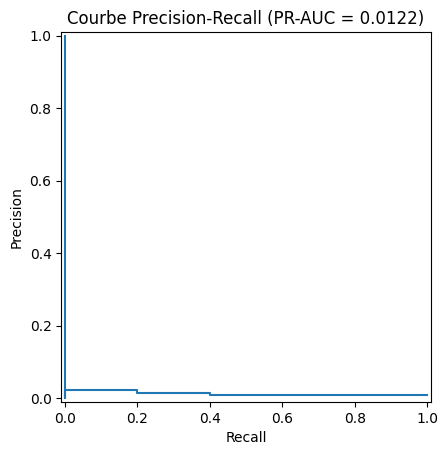

In [7]:
print("\n--- Évaluation du Modèle Random Forest ---")

# Prédictions sur le set de test
y_pred_rf = pipeline_rf.predict(X_test_features)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test_features)[:, 1] # Probas pour la classe 1 (Planète)

# 1. Matrice de Confusion
print("\nMatrice de Confusion :")
#      Prédit 0 | Prédit 1
# Vrai 0
# Vrai 1
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

# 2. Rapport de Classification
# C'est la métrique la plus importante !
# Regardez le F1-Score pour la classe 'Planète (1)'
print("\nRapport de Classification :")
print(classification_report(y_test, y_pred_rf, target_names=['Pas de Planète (0)', 'Planète (1)']))

# 3. Courbe Precision-Recall (LA meilleure métrique pour ce problème)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc = auc(recall, precision)
print(f"\nAire sous la courbe Precision-Recall (PR-AUC): {pr_auc:.4f}")

# Afficher la courbe
print("Affichage de la courbe PR-AUC...")
display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()
plt.title(f"Courbe Precision-Recall (PR-AUC = {pr_auc:.4f})")
plt.show()


Importance des caractéristiques (features) :
              feature  importance
5                skew    0.140349
6                kurt    0.125887
4              median    0.120063
8  mean_of_10_highest    0.111340
3                 max    0.106606
0                mean    0.101065
7   mean_of_10_lowest    0.098906
1                 std    0.068667
9               range    0.063901
2                 min    0.063217


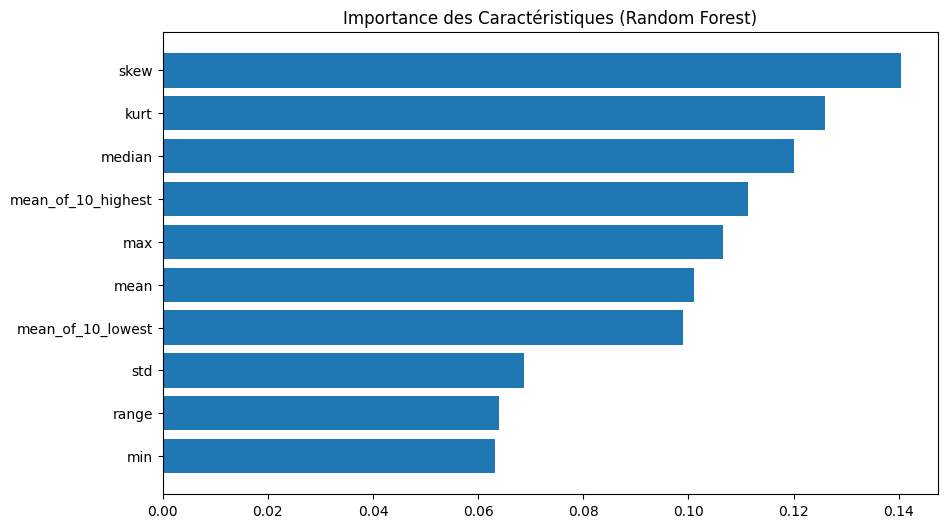

In [8]:
print("\nImportance des caractéristiques (features) :")
# Récupérer les features importances depuis le pipeline
feature_names = X_train_features.columns
importances = pipeline_rf.named_steps['rf'].feature_importances_

# Créer un DataFrame pour mieux visualiser
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

# Visualiser
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Importance des Caractéristiques (Random Forest)')
plt.gca().invert_yaxis()
plt.show()